In [10]:
import os
import re
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio.features import geometry_mask
from shapely.geometry import mapping
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from scipy import ndimage
from functools import partial




In [11]:

# =========================================================
# 2) TRÍCH DATETIME TỪ FILENAME
# =========================================================
def extract_datetime_from_filename(path):
    filename = os.path.basename(path)

    # -------------------------------------------------------
    # LOẠI 1: ERA5 & RADAR (Có chuỗi 14 số liên tiếp)
    # VD: Radar_20190401000000.tif
    # VD: CAPE_20190401000000.tif
    # -------------------------------------------------------
    m14 = re.search(r"(\d{14})", filename)
    if m14:
        # Format: YYYYMMDDHHMMSS
        return pd.to_datetime(m14.group(1), format="%Y%m%d%H%M%S", errors="coerce")

    # -------------------------------------------------------
    # LOẠI 2: HIMA (Ngày riêng, Giờ riêng sau chữ Z)
    # VD: B04B_20190401.Z0000_TB.tif
    # -------------------------------------------------------
    # Regex logic: Tìm 8 số (ngày) + dấu chấm + chữ Z + 4 số (giờ)
    m_hima = re.search(r"(\d{8})\.Z(\d{4})", filename)
    if m_hima:
        d_str = m_hima.group(1) # 20190401
        t_str = m_hima.group(2) # 0000
        # Ghép lại thành 201904010000
        return pd.to_datetime(d_str + t_str, format="%Y%m%d%H%M", errors="coerce")

    return pd.NaT


# =========================================================
# 3) LIST FILE
# =========================================================
def list_all_files(root):
    out = []
    for dp, _, files in os.walk(root):
        for f in files:
            if f.endswith(".tif") or f.endswith(".TIF"):
                out.append(os.path.join(dp, f))
    return out


def fill_nodata_minus9999(arr):
    """
    Fill toàn bộ NaN / +Inf / -Inf thành -9999
    Nhanh, an toàn cho ML (XGBoost / CatBoost / LGBM)
    """
    arr = arr.astype(np.float32, copy=False)
    mask = np.isnan(arr) | np.isinf(arr)
    if mask.any():
        arr[mask] = -9999.0
    return arr

def get_variable_name(path):
    """
    Lấy tên biến từ filename.
    VD: 'B04B_2019....tif' -> trả về 'B04B'
    VD: 'CAPE_2019....tif' -> trả về 'CAPE'
    """
    filename = os.path.basename(path)
    return filename.split('_')[0]

In [12]:
# =========================================================
# 1) LOAD SHAPEFILE HÀ TĨNH
# =========================================================
shp_path = "../gadm41_VNM_shp"
vnm_gdf = gpd.read_file(shp_path)

# Lọc Hà Tĩnh
th_gdf = vnm_gdf[vnm_gdf['VARNAME_1'] == 'Thanh Hoa']

th_union = th_gdf.geometry.union_all()
th_crs = th_gdf.crs

In [13]:
# =========================================================
# 5) EXTRACT PIXELS THANH HÓA
# =========================================================
def extract_ThanhHoa_pixels(path, root):

    try:
        with rasterio.open(path) as src:
            data = src.read(1).astype(float)
            nodata = src.nodata
            transform = src.transform
            src_crs = src.crs

        # --- chuẩn hóa NODATA ---
        data[data == nodata] = np.nan
        data[data == -9999] = np.nan
        data[np.isinf(data)] = np.nan

        data = fill_nodata_minus9999(data)

        # --- reproject THANH HÓA sang CRS raster ---
        if src_crs != th_crs:
            geom = th_gdf.to_crs(src_crs).geometry.union_all()
        else:
            geom = th_union

        # --- tạo mask pixel thuộc THANH HÓA ---
        mask = geometry_mask(
            [mapping(geom)],
            invert=True,
            out_shape=data.shape,
            transform=transform
        )

        rows, cols = np.where(mask)
        vals = data[rows, cols]

        # --- nếu không có pixel trong THANH HÓA ---
        if len(rows) == 0:
            cr = data.shape[0] // 2
            cc = data.shape[1] // 2
            rows, cols = np.array([cr]), np.array([cc])
            vals = np.array([data[cr, cc]])

        # --- chuyển sang lon/lat ---
        lons, lats = rasterio.transform.xy(transform, rows, cols, offset='center')

        # --- timestamp ---
        ts = extract_datetime_from_filename(path)

        # --- variable ---
        rel = os.path.relpath(path, root)
        var = rel.split(os.sep)[0]

        return pd.DataFrame({
            "variable": var,
            "timestamp": ts,
            "row": rows,
            "col": cols,
            "lon": lons,
            "lat": lats,
            "value": vals
        })

    except Exception as e:
        print("ERROR:", path, e)
        return pd.DataFrame({
            "variable": "unknown",
            "timestamp": pd.NaT,
            "row": [0],
            "col": [0],
            "lon": [np.nan],
            "lat": [np.nan],
            "value": [np.nan],
        })


In [14]:
# Lấy ra đối tượng hình học (geometry) ranh giới tỉnh Hà Tĩnh (chỉ 1 hàng)
th_union = th_gdf.geometry.iloc[0]
print(f"Ranh giới tỉnh Hà Tĩnh đã được lọc và sẵn sàng (Geometry Type: {th_union.geom_type})")

ht_crs = vnm_gdf.crs.to_string()  #lấy CRS
print(ht_crs)

print(th_union)

Ranh giới tỉnh Hà Tĩnh đã được lọc và sẵn sàng (Geometry Type: MultiPolygon)
EPSG:4326
MULTIPOLYGON (((105.74184417700013 19.315624237000065, 105.7428131100001 19.31737709100014, 105.74185180700005 19.323535920000154, 105.73661041200006 19.318098067999983, 105.73381042500012 19.318674087000147, 105.73005676200012 19.314531327000054, 105.72465515100004 19.313632965000124, 105.72531890800013 19.311754227000108, 105.71952056900011 19.309074401999965, 105.71562194800003 19.305910111000117, 105.71499633900004 19.303098679000186, 105.7131271360002 19.303249359000006, 105.711219787 19.30212402400008, 105.70902252200005 19.303527832000043, 105.70617675800014 19.303037644000028, 105.70151519700016 19.303878784000176, 105.700271606 19.304370881000125, 105.69669342100019 19.303525924999974, 105.69387817400002 19.30416870200014, 105.69183349600013 19.300350190000074, 105.69076538100012 19.30012130700004, 105.68366241500007 19.3045177460001, 105.68062591600005 19.310609819000092, 105.67801666300011

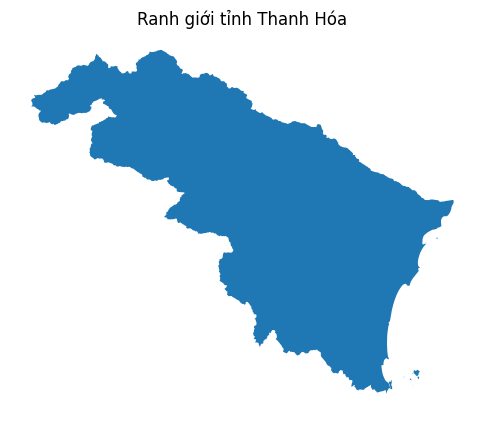

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
gpd.GeoSeries(th_union).plot(ax=ax)

ax.set_title("Ranh giới tỉnh Thanh Hóa")
ax.set_axis_off()
plt.show()


In [18]:

# =========================================================
# 6) MAIN
# =========================================================
if __name__ == "__main__":

    out_csv = "csv_data/tri_an_thanh_hoa/RADAR_ThanhHoa.csv"
    root = "DATA_SV/Precipitation/Radar"

    # out_csv = "csv_data/tri_an_thanh_hoa/HIMA_ThanhHoa.csv"
    # root = "DATA_SV/Hima"

    # out_csv = "csv_data/tri_an_thanh_hoa/ERA5_ThanhHoa.csv"
    # root = "DATA_SV/ERA5"

    os.makedirs(os.path.dirname(out_csv), exist_ok=True)

    files = list_all_files(root)
    print("Tổng file tìm thấy:", len(files))

    if os.path.exists(out_csv):
        os.remove(out_csv)

    func = partial(extract_ThanhHoa_pixels, root=root)
    results = []

    with ThreadPoolExecutor(max_workers=10) as pool:
        futures = [pool.submit(func, f) for f in files]

        for f in tqdm(as_completed(futures), total=len(futures), desc="Process"):
            try:
                df = f.result()
                if df is not None and not df.empty:
                    results.append(df)
            except Exception as e:
                print("Thread error:", e)

    if results:
        final = pd.concat(results, ignore_index=True)
        final.to_csv(out_csv, index=False)
        print("DONE! Tổng pixel =", len(final))
    else:
        print("Không có data.")



Tổng file tìm thấy: 2487


Process: 100%|██████████| 2487/2487 [00:15<00:00, 155.52it/s]


DONE! Tổng pixel = 1482252


In [ ]:
def create_x_y_selected_features(list_path, selected_features=None):
    """
    Phiên bản tối ưu: Sửa lỗi index float, cố định thứ tự band và tăng tốc độ xử lý.
    """
    if selected_features is None:
        selected_features = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB',
                             'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']

    # 1) Đọc CSV và gộp
    dfs = []
    print("[B1] Đọc CSV...")
    for p in tqdm(list_path, desc="Đọc file CSV"):
        # Mẹo: Xác định dtype ngay lúc đọc để tiết kiệm bộ nhớ nếu file lớn
        df = pd.read_csv(p)
        df["variable"] = df["variable"].astype(str)
        # Gán nhãn y
        df.loc[df["variable"].isin(['2019', '2020']), "variable"] = 'y'
        dfs.append(df)

    df_all = pd.concat(dfs, ignore_index=True)

    # 2) Min/Max row/col → tạo hình chữ nhật
    min_row, max_row = df_all["row"].min(), df_all["row"].max()
    min_col, max_col = df_all["col"].min(), df_all["col"].max()
    n_row = int(max_row - min_row + 1)
    n_col = int(max_col - min_col + 1)

    # 3) Xác định danh sách band cần thiết (QUAN TRỌNG: Phải Sort để cố định thứ tự)
    required_bands_list = sorted(list(set(selected_features + ['y'])))
    required_bands_set = set(required_bands_list)
    print(f"-> Số lượng band bắt buộc: {len(required_bands_list)}")

    # 4) Lọc Timestamp hợp lệ (TỐI ƯU HÓA TỐC ĐỘ)
    print("[B2] Lọc timestamp đầy đủ (Vectorized Check)...")

    # Chỉ giữ lại các dòng thuộc các variable quan tâm để đếm cho nhanh
    df_check = df_all[df_all["variable"].isin(required_bands_set)]

    # Đếm số lượng variable unique trong mỗi timestamp
    # Nếu timestamp T1 có đủ 13 variable -> count sẽ là 13
    ts_counts = df_check.groupby("timestamp")["variable"].nunique()

    # Lấy ra các timestamp có số lượng variable bằng đúng số lượng yêu cầu
    valid_ts_index = ts_counts[ts_counts == len(required_bands_set)].index
    ts_valid = sorted(list(valid_ts_index))

    print(f"-> Tìm thấy {len(ts_valid)} timestamp hợp lệ.")

    # 5) Chuẩn bị dữ liệu để đổ vào Tensor
    print("[B3] Chuẩn bị index và Tensor...")

    # Tạo mapping index (Dictionary comprehension)
    t_to_idx = {t: i for i, t in enumerate(ts_valid)}
    b_to_idx = {b: i for i, b in enumerate(required_bands_list)} # Dùng list đã sort

    # Lọc dữ liệu chính thức:
    # - Chỉ lấy timestamp hợp lệ
    # - Chỉ lấy variable nằm trong required_bands (Bước này sửa lỗi Index Float)
    df_valid = df_all[
        (df_all["timestamp"].isin(ts_valid)) &
        (df_all["variable"].isin(required_bands_set))
    ].copy()

    # Map sang index (Ép kiểu int rõ ràng để tránh lỗi)
    df_valid["t_idx"] = df_valid["timestamp"].map(t_to_idx).astype(int)
    df_valid["b_idx"] = df_valid["variable"].map(b_to_idx).astype(int)
    df_valid["r_idx"] = (df_valid["row"] - min_row).astype(int)
    df_valid["c_idx"] = (df_valid["col"] - min_col).astype(int)

    # 6) Đổ dữ liệu vào Tensor (Vectorized - Không cần vòng lặp)
    print("[B4] Đổ dữ liệu vào Tensor...")
    # tensor = np.zeros((len(ts_valid), len(required_bands_list), n_row, n_col), dtype=float)

    tensor = np.full(
        (len(ts_valid), len(required_bands_list), n_row, n_col),
        -9999,
        dtype=float
    )

    # Numpy Advanced Indexing: Nhanh hơn loop rất nhiều
    tensor[df_valid["t_idx"].values,
           df_valid["b_idx"].values,
           df_valid["r_idx"].values,
           df_valid["c_idx"].values] = df_valid["value"].values

    # 7) Tách X và y
    y_idx = b_to_idx['y']
    # Lấy mảng X indices: loại bỏ index của y
    x_indices = [i for i, b in enumerate(required_bands_list) if b != 'y']

    y = tensor[:, [y_idx], :, :]
    x = tensor[:, x_indices, :, :]

    return x, y, ts_valid, required_bands_list, (min_row, max_row), (min_col, max_col)

In [ ]:
def luuTensor():
    list_file = [
        'csv_data/tri_an_thanh_hoa/HIMA_thanhhoa.csv',
        'csv_data/ERA5_hatinh.csv',
        'csv_data/RADAR_hatinh.csv'
    ]

    x, y, timestamps, x_bands, row_range, col_range = create_x_y_selected_features(list_file)

    print("[B4] Lưu tensor...")
    np.save("csv_data/x_hatinh.npy", x)
    np.save('csv_data/y_hatinh.npy', np.squeeze(y, axis=1))

luuTensor()